In [183]:
import simulate_data
import remove_data
import matrix_completion
import trunc_nnm
import errors

from sklearn.preprocessing import Normalizer
import numpy as np
import numpy.linalg as la
import pandas as pd

In [184]:
# simulate data
sim_df = simulate_data.sim_data(**simulate_data.sim_params)

# drop categorical feature for now
sim_df = sim_df.drop("Group", axis=1)

# normalize data
nrml = Normalizer()
sim_norm = nrml.fit_transform(sim_df)

pd.DataFrame(sim_norm).head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.000972,0.694418,0.000024,0.000000,0.0,0.000012,0.000012,-0.000000,0.000000,0.023743,0.719180
1,0.001275,0.624960,0.000000,0.000000,0.0,0.000022,0.000022,0.000000,0.052415,0.094452,0.773146
2,0.000465,0.691109,0.000010,0.000010,0.0,0.000010,0.000010,0.000000,0.000000,0.030493,0.722107
3,0.000466,0.699460,0.000000,0.000009,0.0,0.000000,0.000009,0.000000,0.000000,0.014580,0.714523
4,0.000634,0.680330,0.000024,0.000012,0.0,0.000000,0.000012,0.011341,0.000000,0.039404,0.731757


In [185]:
# NNM parameters
parameters = {"eps_outer": 1e-4,
                  "eps_inner": 1e-4,
                  "beta": .5,
                  "max_iter_outer": 1000,
                  "max_iter_inner": 1000}

# Missing at Random

### How do error rates vary by rate of missingness?

In [149]:
results_lst = []

for missingness_pct in np.arange(0, 1, .05):
    sim_obs = remove_data.missing_at_random(sim_norm, perc_remove=missingness_pct, rand_seed=23)
    
    sim_recovered_svt = matrix_completion.svt(sim_obs, tau=5)
    svt_error = la.norm(np.round(sim_norm, 4) - np.round(sim_recovered_svt, 4), ord='fro')
    
    sim_recovered_nnm = trunc_nnm.truncated_NNM(10, parameters, sim_obs)
    nnm_error = la.norm(np.round(sim_norm, 4) - np.round(sim_recovered_nnm, 4), ord='fro')
    
    results_lst.append([missingness_pct, svt_error, nnm_error])

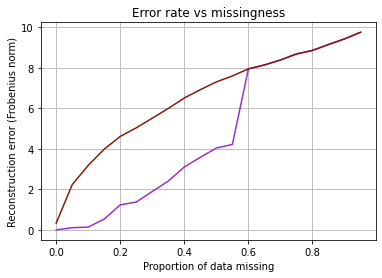

In [96]:
results_df = pd.DataFrame(results_lst, columns=["missingness", "SVT", "NNM"]).set_index("missingness")
errors.line_plot(results_df.index, results_df.SVT, results_df.NNM)

NNM seems to be pretty stable across parameters, but SVT results can change depending on $\tau$. SVT seems to converve with NNM results quite exactly when $\tau$ is really small or really large.

##### Here we hold the error rate at 40% and change $\tau$ for SVT

In [5]:
tau_lst = []

for tau in np.arange(0, 10, 1):
    sim_obs = remove_data.missing_at_random(sim_norm, perc_remove=0.4, rand_seed=23)
    
    sim_recovered_svt = matrix_completion.svt(sim_obs, tau=tau)
    svt_error = la.norm(np.round(sim_norm, 4) - np.round(sim_recovered_svt, 4), ord='fro')
    
    tau_lst.append([tau, svt_error])

<AxesSubplot:title={'center':'Error rate depending on tau'}, xlabel='tau'>

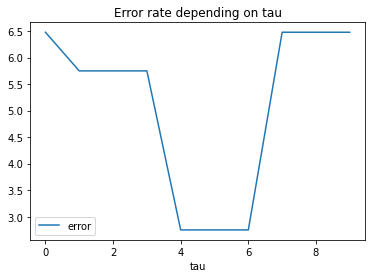

In [6]:
tau_df = pd.DataFrame(tau_lst, columns=["tau", "error"]).set_index("tau")
tau_df.plot(title="Error rate depending on tau")

SVT seems to want $\tau$ to be somewhere midway between 0 and the rank of the original matrix. Should test on other data.

### How do error rates vary by rank of the matrix?

### How do error rates vary by the type of missingness?

In [63]:
# or make dataframe with columns: random, slightly conditional, very conditional
# then the rows would be percent missingness

In [234]:
# create conditionally missing data
sim_norm_df = pd.DataFrame(sim_norm, columns=sim_df.columns)
sim_conditional_missing = remove_data.missing_conditional_continuous(sim_norm_df, "Income", "Age", 60)
sim_conditional_missing = remove_data.missing_conditional_continuous(sim_conditional_missing, "Income", "Age", 60)
sim_conditional_missing = remove_data.missing_conditional_continuous(sim_conditional_missing, "Income", "Age", 60)
# sim_conditional_missing = remove_data.missing_conditional_continuous(sim_conditional_missing, "Continuous_HighLikelihood_0", "Income", 5)
sim_conditional_missing = remove_data.missing_conditional_continuous(sim_conditional_missing, "Continuous_LowLikelihood_0", "Discrete_EvenLikelihood_0", 100)

In [235]:
# view where the missingness is
sim_conditional_missing.isnull().sum()

Age                             0
Income                         66
NChild                          0
InCensus                        0
Discrete_LowLikelihood_0        0
Discrete_EvenLikelihood_0       0
Discrete_HighLikelihood_0       0
Continuous_LowLikelihood_0     35
Continuous_EvenLikelihood_0     0
Continuous_HighLikelihood_0     0
PerfectClassifierOutcome        0
dtype: int64

In [236]:
percent_missing = sim_conditional_missing.isnull().sum().sum() / sim_conditional_missing.size
percent_missing

0.09181818181818181

In [237]:
sim_random_missing = remove_data.missing_at_random(sim_norm, perc_remove=percent_missing, rand_seed=23)
pd.DataFrame(sim_random_missing).isnull().sum().sum() / pd.DataFrame(sim_random_missing).size

0.09181818181818181

In [238]:
# random missing
sim_recovered_random_svt = matrix_completion.svt(sim_random_missing, tau=5)
svt_error = la.norm(np.round(sim_norm, 4) - np.round(sim_recovered_random_svt, 4), ord='fro')

sim_recovered_random_nnm = trunc_nnm.truncated_NNM(10, parameters, sim_random_missing)
nnm_error = la.norm(np.round(sim_norm, 4) - np.round(sim_recovered_random_nnm, 4), ord='fro')

# results_lst.append([missingness_pct, svt_error, nnm_error])
print(svt_error, nnm_error)

0.1667114873066641 3.197247333254029


For 10% random missingness, both errors are around 3.17

In [239]:
# conditional missing
sim_recovered_conditional_svt = matrix_completion.svt(sim_conditional_missing, tau=5)
svt_error = la.norm(np.round(sim_norm, 4) - np.round(sim_recovered_conditional_svt, 4), ord='fro')

sim_recovered_conditional_nnm = trunc_nnm.truncated_NNM(10, parameters, sim_conditional_missing)
nnm_error = la.norm(np.round(sim_norm, 4) - np.round(sim_recovered_conditional_nnm, 4), ord='fro')

print(svt_error, nnm_error)

0.2792271834904331 5.547132886455849


For 10% conditional missingness, both errors are much higher, around 5.7